In [1]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
sns.set(color_codes=True)

In [3]:
def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None
    
def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)

In [100]:
raw_html = simple_get(url = r'https://www.blocket.se/hela_sverige?q=family&cg=1020&w=3&st=s&ps=&pe=&mys=&mye=&ms=&me=&cxpf=&cxpt=&fu=&gb=&ca=15&is=1&l=0&md=th&cp=&cb=7&cbl1=1')

In [101]:
html = BeautifulSoup(raw_html, 'html.parser')

In [102]:
item_list = html.find_all('div',attrs = {'class':'media-body desc'})

In [103]:
item = item_list[0]

In [104]:
a = item.find('div',attrs = {'class':'pull-left'})
place = a.contents[-1]
place

'Örebro'

In [105]:
href = item.find('a',attrs = {'class':'item_link'}).get('href')
href

'https://www.blocket.se/orebro/Citroen_Berlingo_Family_Multispace_1_6_HDi_80925289.htm?ca=15&w=3'

In [106]:
raw_html2 = simple_get(href)
html2 = BeautifulSoup(raw_html2, 'html.parser')

In [107]:
header = html2.find('h1')
name = header.text.replace('\n','').replace('\t','')
name


'Citroën Berlingo Family Multispace 1.6 HDi -13'

In [110]:
extra_data = html2.find('dl',attrs={'class':'col-xs-12 motor-extradata-details'})
extra_data

<dl class="col-xs-12 motor-extradata-details"><dt class="col-xs-3 npl">Märke</dt><dd class="col-xs-3 npl">Citroën</dd><dt class="col-xs-3 npl">Biltyp</dt> <dd class="col-xs-3 npl">Kombi</dd><dt class="col-xs-3 npl">Modell</dt><dd class="col-xs-3 npl"> 7 BERLINGO</dd><dt class="col-xs-3 npl">Färg</dt><dd class="col-xs-3 npl">Silver</dd><dt class="col-xs-3 npl">I trafik</dt><dd class="col-xs-3 npl">2013-02-18</dd><dt class="col-xs-3 npl">Drivhjul</dt><dd class="col-xs-3 npl">Tvåhjulsdriven</dd><dt class="col-xs-3 npl">Hästkrafter</dt><dd class="col-xs-3 npl">92 Hk</dd><dt class="col-xs-3 npl">CO<sub id="co2_subscript">2</sub>-utsläpp</dt><dd class="col-xs-3 npl">-</dd></dl>

In [111]:
extra_data.findAll('dt')

[<dt class="col-xs-3 npl">Märke</dt>,
 <dt class="col-xs-3 npl">Biltyp</dt>,
 <dt class="col-xs-3 npl">Modell</dt>,
 <dt class="col-xs-3 npl">Färg</dt>,
 <dt class="col-xs-3 npl">I trafik</dt>,
 <dt class="col-xs-3 npl">Drivhjul</dt>,
 <dt class="col-xs-3 npl">Hästkrafter</dt>,
 <dt class="col-xs-3 npl">CO<sub id="co2_subscript">2</sub>-utsläpp</dt>]

In [112]:
extra_data.findAll('dd')

[<dd class="col-xs-3 npl">Citroën</dd>,
 <dd class="col-xs-3 npl">Kombi</dd>,
 <dd class="col-xs-3 npl"> 7 BERLINGO</dd>,
 <dd class="col-xs-3 npl">Silver</dd>,
 <dd class="col-xs-3 npl">2013-02-18</dd>,
 <dd class="col-xs-3 npl">Tvåhjulsdriven</dd>,
 <dd class="col-xs-3 npl">92 Hk</dd>,
 <dd class="col-xs-3 npl">-</dd>]

In [38]:
def clean_string(s):
    s_clean = s.replace('\n','').replace('\t','')
    return s_clean

def clean_string2(s):
    s_clean = clean_string(s).replace(' ','')
    return s_clean

def clean_price(s):
    s_clean = clean_string(s)
    s_clean = s_clean.replace('kr','').replace(' ','')
    price = float(s_clean)
    return price

def find_id_from_href(href):
    
    result = re.search(pattern = r'(\d*).htm',string = href)
    id = int(result.groups(1)[0])
    return id
    
def parse_car(href):
    
    raw_html = simple_get(href)
    html = BeautifulSoup(raw_html, 'html.parser')
    
    header = html.find('h1')
    name = clean_string(header.text)
    
    item_details = html.find('div',attrs = {'id':'item_details'})
    items = item_details.find_all('dl',attrs={'class':'col-xs-4'})
    
    data = pd.Series()
    for item in items:
        key = clean_string2(item.find('dt').text)
        value = clean_string2(item.find('dd').text)
        data[key] = value
        
    data['header'] = name
    data.name = find_id_from_href(href = href)
    
    price = html.find('div',attrs={'id':'vi_price'})
    data['price'] = clean_price(price.text)
    
    return data
        
    
        

In [88]:
parse_car(href = href)

Modellår                                                     2013
Växellåda                                                 Manuell
Miltal                                                       9065
Tillverkningsår                                              2013
Bränsle                                                    Diesel
header             Citroën Berlingo Family Multispace 1.6 HDi -13
price                                                       89900
Name: 80925289, dtype: object

In [42]:
df_cars = pd.DataFrame()

In [89]:
car_paths = OrderedDict()
car_paths['kangoo'] = r'https://www.blocket.se/hela_sverige?q=&cg=1020&w=3&st=s&ps=&pe=&mys=&mye=&ms=&me=&cxpf=&cxpt=&fu=&gb=&ccco=1&ca=15&is=1&l=0&md=th&cp=&cb=30&cbl1=4'
car_paths['berlingo'] = r'https://www.blocket.se/hela_sverige?q=&cg=1020&w=3&st=s&ps=&pe=&mys=&mye=&ms=&me=&cxpf=&cxpt=&fu=&gb=&ca=15&is=1&l=0&md=th&cp=&cb=7&cbl1=1'
car_paths['caddy'] = r'https://www.blocket.se/hela_sverige?q=&cg=1020&w=3&st=s&ps=&pe=&mys=&mye=&ms=&me=&cxpf=&cxpt=&fu=&gb=&ccco=1&ca=15&is=1&l=0&md=th&cp=&cb=40&cbl1=2'



In [92]:
def get_cars(car_path,max_cars = None):

    next_page_href = car_path
    df_cars = pd.DataFrame()
    counter = 0

    while not next_page_href is None:
        
        raw_html = simple_get(url = next_page_href)
        html = BeautifulSoup(raw_html, 'html.parser')
        item_list = html.find_all('div',attrs = {'class':'media-body desc'})
        
        for item in item_list:
            
            if not max_cars is None:
                if counter > max_cars:
                    return df_cars
            
            href = item.find('a',attrs = {'class':'item_link'}).get('href')
            
            try:
                s_car = parse_car(href = href).copy()
            except AttributeError:
                continue
            else:
                a = item.find('div',attrs = {'class':'pull-left'})
                place = a.contents[-1]
                s_car['place'] = place
                df_cars = df_cars.append(s_car)
                
            counter+=1
            
        next_page = html.find('a',attrs = {'class':'page_nav'},text = '\n                Nästa sida »\n            ')
        if next_page is None:
            next_page_href = None
        else:
            next_page_href = r'https://www.blocket.se/hela_sverige' + next_page['href']
            
    return df_cars    

In [93]:
df_cars = pd.DataFrame()

for car_type,car_path in car_paths.items():
    
    df_car_type_cars = get_cars(car_path = car_path)
    df_car_type_cars['car type'] = car_type
    df_cars = df_cars.append(df_car_type_cars)
     

In [94]:
index = df_cars['Tillverkningsår'] == '-'
df_cars.loc[index,'Tillverkningsår'] = df_cars.loc[index,'Modellår']

In [95]:
def decode_miltal(s_miltal):
    
    parts = s_miltal.split('-')
    
    if len(parts) == 1:
        return float(parts[0])
    elif len(parts) == 2:
        return np.mean([float(parts[0]),float(parts[1])])
    else:
        raise ValueError()
    

In [96]:
df_cars['Miltal'] = df_cars['Miltal'].apply(func = decode_miltal)

In [49]:
float_cols = ['Miltal','Modellår','Tillverkningsår']
df_cars[float_cols] = df_cars[float_cols].astype(float)

In [50]:
index = (df_cars['price'] > 2000)
df_cars = df_cars.loc[index]

In [55]:
try:
    old_cars = pd.read_csv('cars.csv',sep = ';',index_col = 0)
except:
    pass
else:
    df_cars = df_cars.combine_first(old_cars)

In [56]:
df_cars.to_csv('cars.csv',sep = ';')

In [57]:
len(df_cars)

212

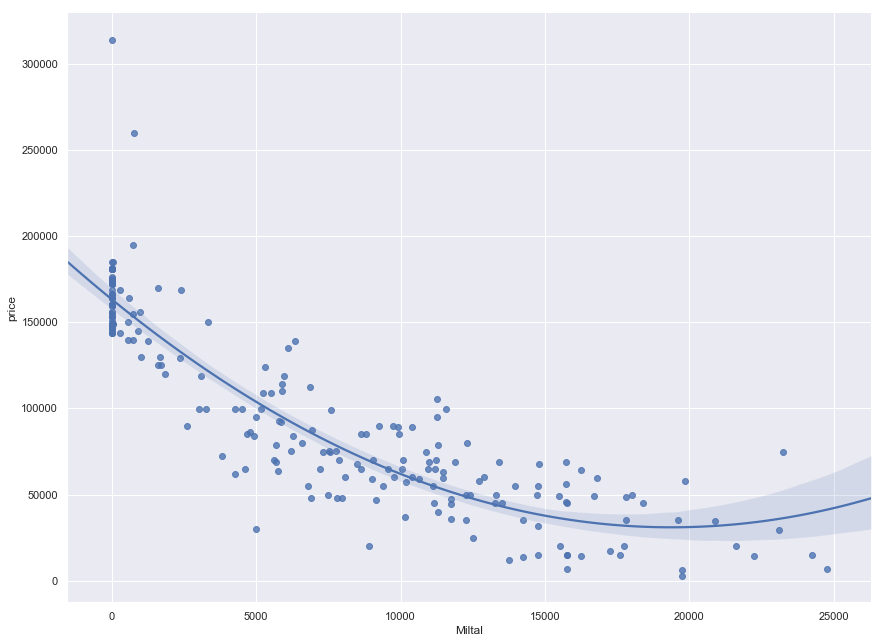

In [58]:
a = sns.lmplot(x="Miltal", y="price", data=df_cars,order=2)
a.fig.set_size_inches(15,10)

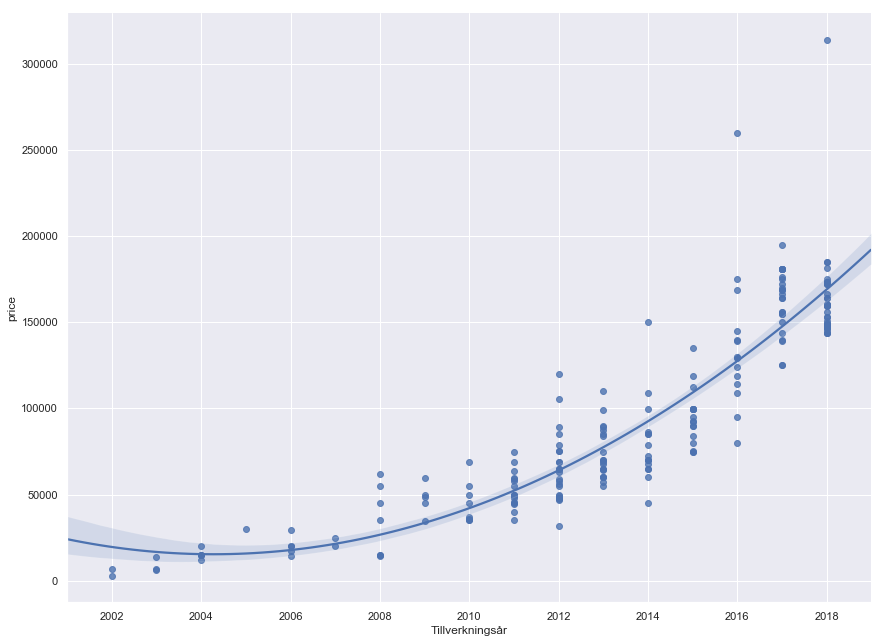

In [59]:
a = sns.lmplot(x="Tillverkningsår", y="price", data=df_cars,order = 2)
a.fig.set_size_inches(15,10)

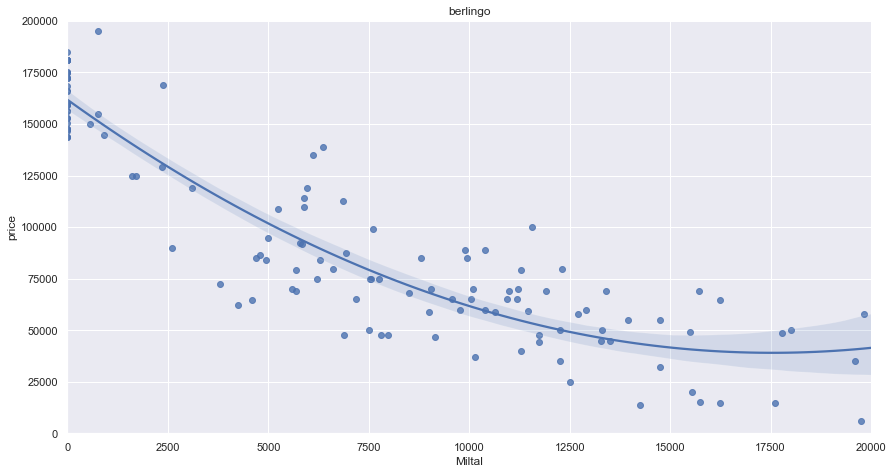

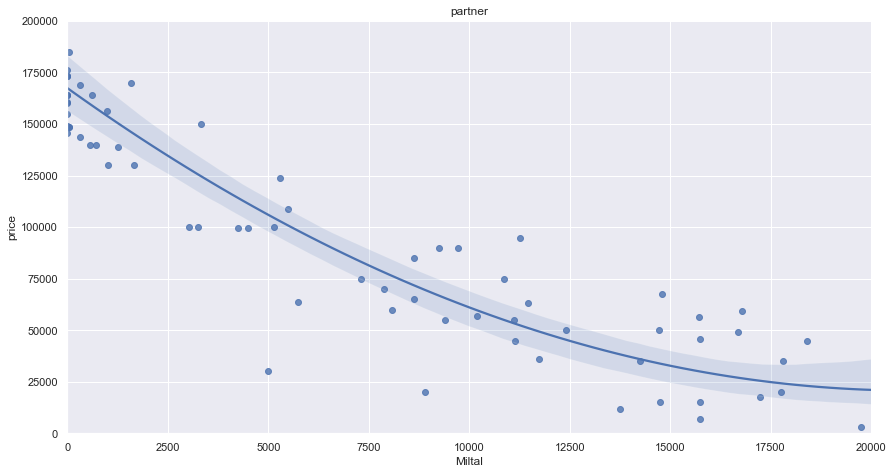

In [60]:
for car_type,group in df_cars.groupby(by = 'car type'):
    
    if len(group) < 10:
        continue
    
    a = sns.lmplot(x="Miltal", y="price", data=group,order = 2)
    fig = a.fig
    fig.set_size_inches(15,7)
    ax = a.ax
    ax.set_title(car_type)
    ax.set_xlim((0,20000))
    ax.set_ylim((0,200000))
    

In [31]:
index = df_cars['car type'] == 'berlingo'
df_berlingo = df_cars.loc[index]

In [32]:
index = df_cars['header'].str.contains('family')

In [33]:
df_cars.loc[index]

,Bränsle,Miltal,Modellår,Tillverkningsår,Växellåda,header,price,car type
79545167,Bensin,17790.0,2010.0,2009.0,Manuell,Citroën Berlingo 1.6 family / 5 SITS -10,48500.0,berlingo
80304471,Bensin,17790.0,2010.0,2009.0,Manuell,Citroën Berlingo 1.6 family / 5 SITS -10,48500.0,berlingo
